In [1]:
import sys
sys.path.append("/home/gonzalo/sw/git/Jupytools/")
sys.path.append("/home/gonzalo/sw/git/resin/python/")

from collections import defaultdict
from itertools   import permutations
from path import Path
from time import time

import numpy  as np
import polars as pl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader

from dataset import DS
from arch import *

from nbtools import auto_plot_style
from pltools import normhist

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

auto_plot_style()

In [3]:
folder = Path("/home/gonzalo/data/NEXT/resin/16x16/double_point/full_chamber/")
filenames = folder.glob("*.parquet")
len(filenames)

1000

# Data quality check

In [4]:
filename = filenames[1]
df       = pl.read_parquet(filename)
pos      = df.select("x_0 y_0".split())
response = df.select(pl.col("^sipm.*$"))
df.head()

x_0,y_0,x_1,y_1,xabs_0,yabs_0,xabs_1,yabs_1,sipm_0,sipm_1,sipm_2,sipm_3,sipm_4,sipm_5,sipm_6,sipm_7,sipm_8,sipm_9,sipm_10,sipm_11,sipm_12,sipm_13,sipm_14,sipm_15,sipm_16,sipm_17,sipm_18,sipm_19,sipm_20,sipm_21,sipm_22,sipm_23,sipm_24,sipm_25,sipm_26,sipm_27,sipm_28,…,sipm_219,sipm_220,sipm_221,sipm_222,sipm_223,sipm_224,sipm_225,sipm_226,sipm_227,sipm_228,sipm_229,sipm_230,sipm_231,sipm_232,sipm_233,sipm_234,sipm_235,sipm_236,sipm_237,sipm_238,sipm_239,sipm_240,sipm_241,sipm_242,sipm_243,sipm_244,sipm_245,sipm_246,sipm_247,sipm_248,sipm_249,sipm_250,sipm_251,sipm_252,sipm_253,sipm_254,sipm_255
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-2.270884,3.401582,1.134037,3.613713,-2.270884,33.401582,1.134037,33.613713,0.000098,0.00012,0.000147,0.000178,0.000212,0.000246,0.000276,0.000296,0.000302,0.000292,0.000268,0.000236,0.000201,0.000168,0.000138,0.000113,0.000119,0.00015,0.000189,0.000237,0.000294,0.000356,0.000413,0.000453,0.000465,0.000444,0.000397,0.000337,0.000276,…,0.000477,0.000373,0.000286,0.000219,0.000168,0.000116,0.000146,0.000183,0.000229,0.000283,0.00034,0.000393,0.00043,0.000441,0.000422,0.000379,0.000323,0.000266,0.000215,0.000171,0.000136,0.000096,0.000117,0.000143,0.000172,0.000204,0.000236,0.000264,0.000283,0.000288,0.000279,0.000257,0.000227,0.000194,0.000163,0.000135,0.000111
-2.600795,-1.665898,0.358569,1.598407,-132.600795,-21.665898,-129.641431,-18.401593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000441,0.000472,0.000472,0.000439,0.000384,0.000321,0.00026,…,0.000431,0.000335,0.000257,0.000197,0.000152,0.000125,0.000156,0.000195,0.000243,0.000296,0.000351,0.000398,0.000426,0.000426,0.000399,0.000353,0.000298,0.000244,0.000196,0.000157,0.000125,0.000102,0.000124,0.00015,0.00018,0.000211,0.000242,0.000266,0.00028,0.00028,0.000267,0.000242,0.000212,0.00018,0.000151,0.000124,0.000102
-4.209514,-2.300423,4.899623,-0.862996,-144.209514,-62.300423,-135.100377,-60.862996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.000446,0.000341,0.000258,0.000196,0.00015,0.000133,0.000168,0.000212,0.000265,0.000326,0.000389,0.000441,0.00047,0.000465,0.000429,0.000372,0.000309,0.000249,0.000198,0.000157,0.000124,0.000109,0.000133,0.000162,0.000195,0.00023,0.000263,0.00029,0.000304,0.000302,0.000284,0.000255,0.00022,0.000185,0.000153,0.000125,0.000102
0.333484,-3.745506,-1.94575,4.907025,-19.666516,-33.745506,-21.94575,-25.092975,0.000105,0.000128,0.000156,0.000188,0.000222,0.000256,0.000284,0.0003,0.000302,0.000288,0.000261,0.000228,0.000194,0.000161,0.000132,0.000108,0.000128,0.000161,0.000203,0.000254,0.000313,0.000374,0.000427,0.00046,0.000463,0.000435,0.000384,0.000324,0.000264,…,0.000438,0.000342,0.000263,0.000201,0.000155,0.000125,0.000157,0.000196,0.000244,0.000299,0.000354,0.000401,0.000429,0.00043,0.000403,0.000357,0.000302,0.000248,0.0002,0.000159,0.000127,0.000102,0.000125,0.000151,0.000181,0.000213,0.000243,0.000268,0.000282,0.000282,0.000269,0.000245,0.000215,0.000183,0.000153,0.000126,0.000104
4.861048,3.036681,-4.070705,-2.950862,-75.138952,-116.963319,-84.070705,-122.950862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000294,0.000293,0.000276,0.00025,0.000217,0.000184,0.000153,0.000126,0.000103,0.0,0.0,0.0,0.0,0.0,0.0,0.000424,0.000451,0.000448,0.000416,0.000364,0.000305,0.000248,…,0.000473,0.000363,0.000275,0.000208,0.000159,0.000128,0.000161,0.000203,0.000254,0.000313,0.000375,0.00043,0.000465,0.000468,0.000439,0.000386,0.000323,0.000262,0.000209,0.000165,0.000131,0.000105,0.000128,0.000156,0.000188,0.000222,0.000256,0.000285,0.000302,0.000303,0.000289,0.000262,0.000228,0.000193,0.00016,0.000131,0.000107


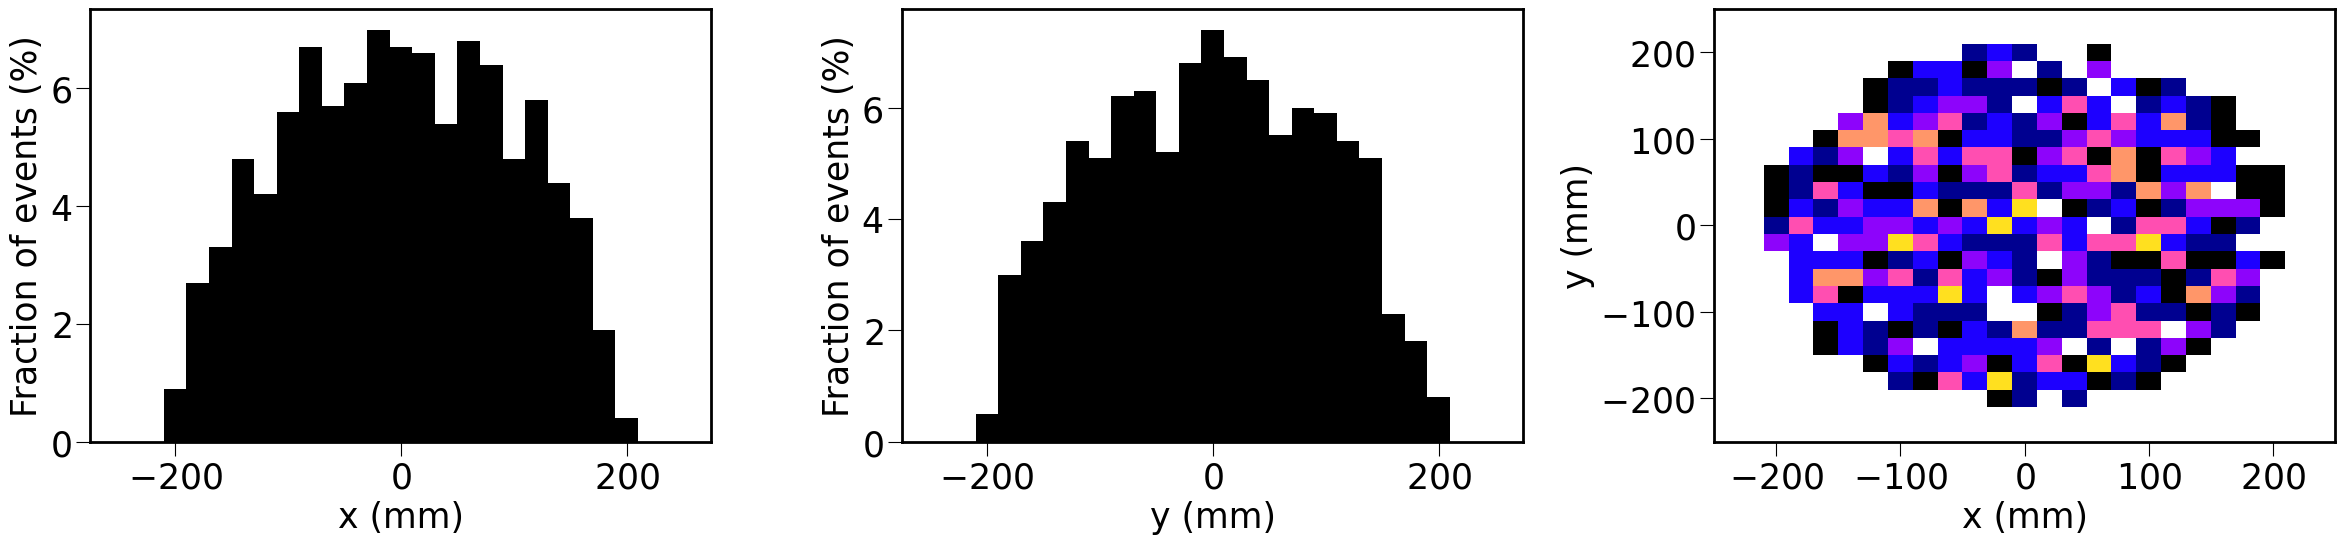

In [5]:
x = df.get_column("xabs_0")
y = df.get_column("yabs_0")

bins_xy = np.linspace(-250, 250, 26)

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1); normhist(x, bins_xy); plt.xlabel("x (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 2); normhist(y, bins_xy); plt.xlabel("y (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 3); plt.hist2d(x, y, (bins_xy,)*2, cmin=1); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

plt.tight_layout()

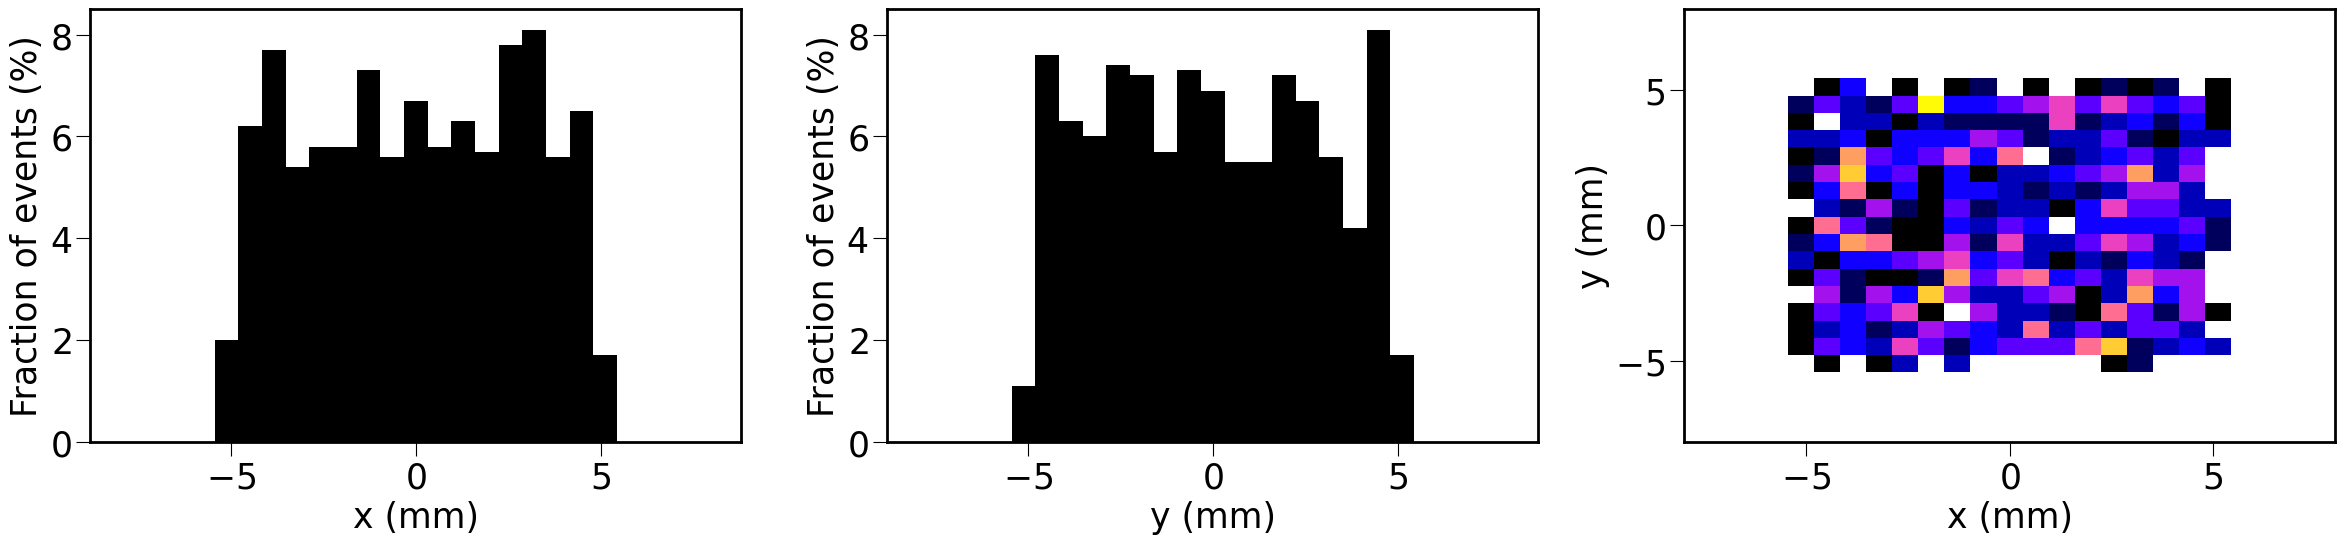

In [6]:
x = df.get_column("x_0")
y = df.get_column("y_0")

bins_xy = np.linspace(-8, 8, 26)

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1); normhist(x, bins_xy); plt.xlabel("x (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 2); normhist(y, bins_xy); plt.xlabel("y (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 3); plt.hist2d(x, y, (bins_xy,)*2, cmin=1); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

plt.tight_layout()

16


Text(0, 0.5, 'y (mm)')

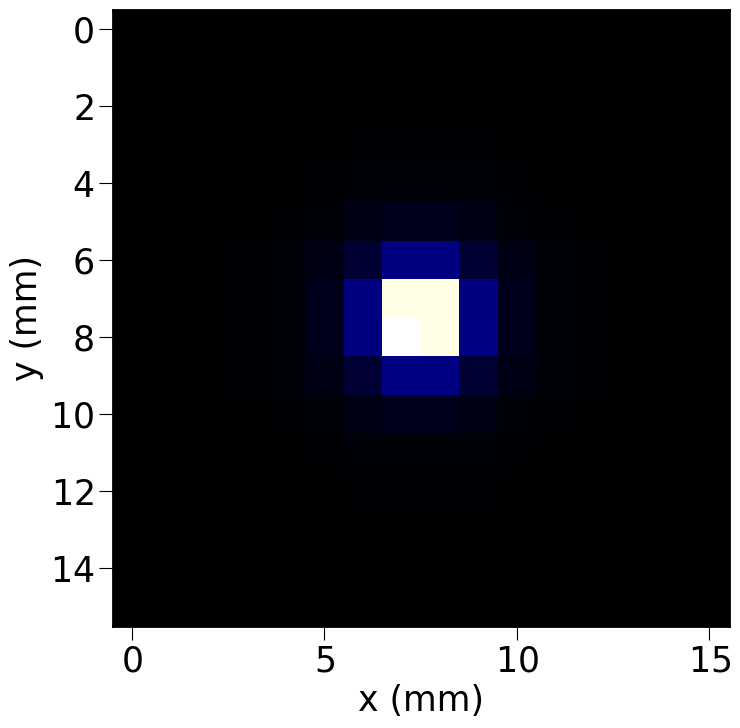

In [7]:
n   = int(response.width**0.5)
print(n)
img = response.sum().to_numpy().reshape(n, n).T
plt.imshow(img); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

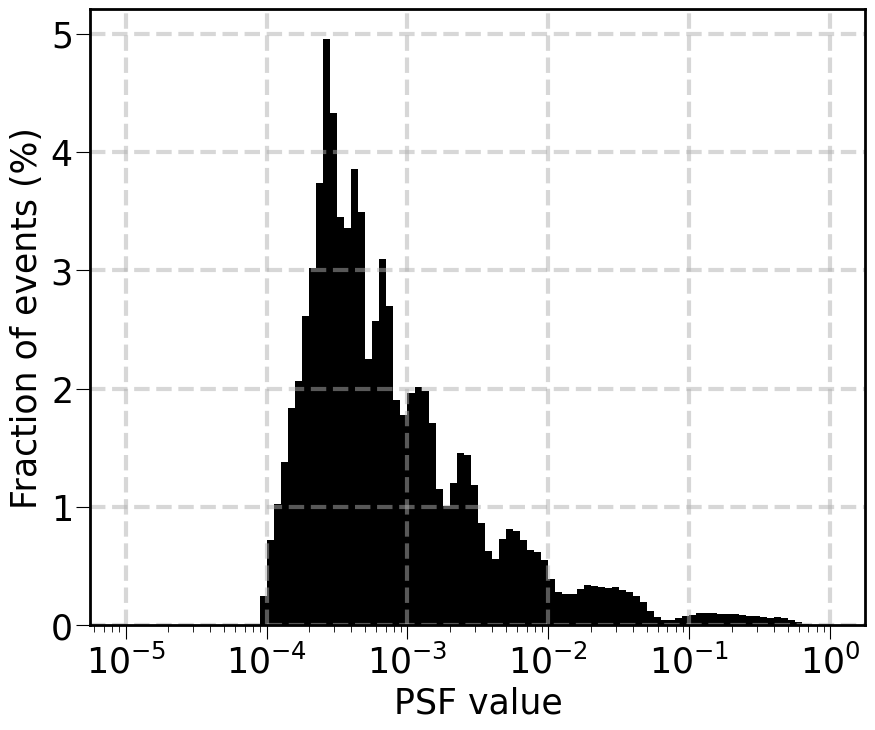

In [8]:
data = np.concatenate([s.to_numpy() for s in response.get_columns()])
normhist(data, np.logspace(-5, 0, 101))
plt.xscale("log")
plt.xlabel("PSF value")
plt.ylabel("Fraction of events (%)")
plt.grid()

# Net

## Data loading

In [4]:
f_train = 80
f_valid = 10
assert f_train + f_valid < 100

In [14]:
ds = DS(folder, 10, fluctuate=True)

idx_train, idx_valid, idx_test = ds.indices(f_train, f_valid)

ds_train = Subset(ds, idx_train); print(f"Training   data: {len(ds_train):>6d}")
ds_valid = Subset(ds, idx_valid); print(f"Validation data: {len(ds_valid):>6d}")
ds_test  = Subset(ds, idx_test ); print(f"Testing    data: {len(ds_test) :>6d}")

loader_train = DataLoader(ds_train, batch_size=min(1000, ds.n_per_file), shuffle=False)
loader_valid = DataLoader(ds_valid, batch_size=min(1000, ds.n_per_file), shuffle=False)
loader_test  = DataLoader(ds_test , batch_size=min(1000, ds.n_per_file), shuffle=False)

Training   data:   8000
Validation data:   1000
Testing    data:   1000


## Training

##### Sensible trainings
- linear v0 seed = 15945278987002563668 nfiles =   10 lr = 1e-4 nepochs = 20
- linear v0 seed = 16896108185643863306 nfiles =  100 lr = 1e-5 nepochs = 30
- linear v0 seed =  2989494183513620518 nfiles =   10 lr = 1e-4 nepochs = 50
- linear v1 seed =  1802610105865725067 nfiles =  100 lr = 1e-5 nepochs = 20
- linear v1 seed = 17773296220054543699 nfiles = 1000 lr = 2e-5 nepochs =  8

In [18]:
torch.seed()
#torch.manual_seed(1234567890)
print("seed =", torch.initial_seed())
nsipms_side = 16
nsipms      = nsipms_side**2
lr          = 3e-5
nepochs     = 50
NN          = NN_conv_v1
model       = NN(nsipms, ds.n_outputs)
lossf       = nn.MSELoss()
optimizer   = optim.Adam(model.parameters(), lr=lr)
losses      = defaultdict(list)

for epoch in range(1, 1+nepochs):
    t0 = time()
    model.train() # inform the model that we are training
    optimizer.zero_grad()
    for i, (pos, response) in enumerate(loader_train, start=1):
        prediction = model(response)
        loss       = lossf(prediction, pos)
        loss     .backward()
        optimizer.step()

        losses[epoch].append(loss.data.item())
        
    validation_loss = []
    with torch.no_grad():
        model.eval() # tell the model that we are evaluating
        for i, (pos, response) in enumerate(loader_valid, start=1):
            prediction = model(response)
            loss       = lossf(prediction, pos)
            validation_loss.append(loss.data.item())
            
    dt = time() - t0
    print(f"Epoch [{epoch}/{nepochs}], Loss: {losses[epoch][-1]:.4f}, Val loss: {np.mean(validation_loss):.1f}, LR: {lr : .4f} DT : {dt:.1f}")
    #lr = max(0.75 * lr, 1e-4)

seed = 16440640525399564227
Epoch [1/50], Loss: 8.6910, Val loss: 8.2, LR:  0.0000 DT : 11.6
Epoch [2/50], Loss: 8.2781, Val loss: 8.2, LR:  0.0000 DT : 11.8
Epoch [3/50], Loss: 7.9409, Val loss: 8.2, LR:  0.0000 DT : 12.3
Epoch [4/50], Loss: 7.6379, Val loss: 8.3, LR:  0.0000 DT : 12.1
Epoch [5/50], Loss: 7.3487, Val loss: 8.2, LR:  0.0000 DT : 11.9
Epoch [6/50], Loss: 7.0631, Val loss: 8.1, LR:  0.0000 DT : 12.5
Epoch [7/50], Loss: 6.7771, Val loss: 8.0, LR:  0.0000 DT : 12.6
Epoch [8/50], Loss: 6.4896, Val loss: 7.7, LR:  0.0000 DT : 12.3
Epoch [9/50], Loss: 6.2007, Val loss: 7.3, LR:  0.0000 DT : 12.0
Epoch [10/50], Loss: 5.9190, Val loss: 6.8, LR:  0.0000 DT : 12.2
Epoch [11/50], Loss: 5.6538, Val loss: 6.2, LR:  0.0000 DT : 12.0
Epoch [12/50], Loss: 5.4163, Val loss: 5.7, LR:  0.0000 DT : 12.8
Epoch [13/50], Loss: 5.2111, Val loss: 5.3, LR:  0.0000 DT : 12.7
Epoch [14/50], Loss: 5.0378, Val loss: 5.1, LR:  0.0000 DT : 12.3
Epoch [15/50], Loss: 4.8950, Val loss: 4.9, LR:  0.0000 D

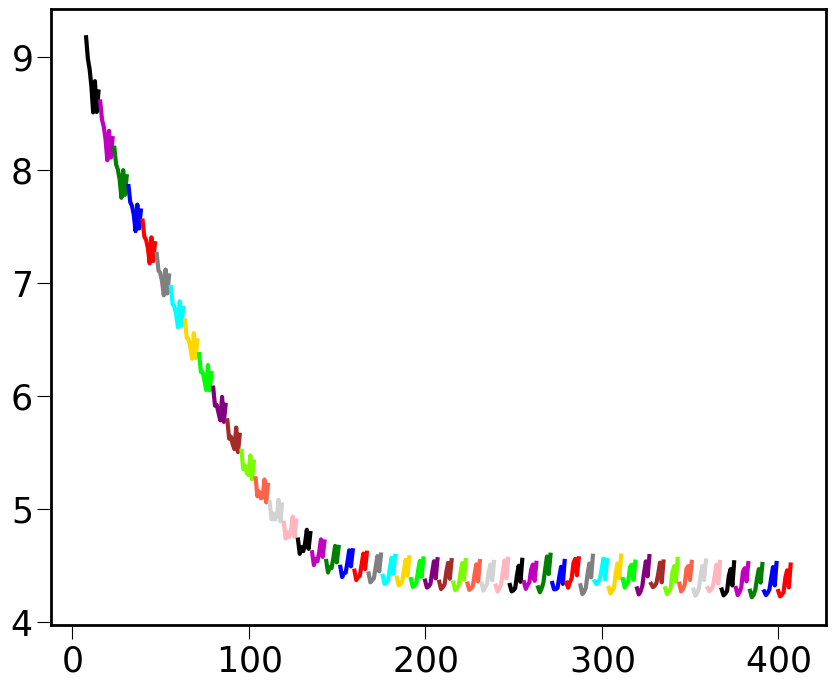

In [19]:
for ie, ep in sorted(losses.items()):
    plt.plot(np.arange(len(ep))+ie*len(ep), ep)

## Testing

In [20]:
def find_best_order(predicted, pos):
    n      = pos.shape[1] // 2    
    orders = []
    for pred, true in zip(predicted, pos):
        best_order = None
        best_delta = np.inf
        for perm in map(np.asarray, permutations(range(n))):
            order = np.vstack([n*perm, n*perm+1]).T.flatten()
            delta = np.sum((pred[order] - true)**2)
            if delta < best_delta:
                best_delta = delta
                best_order = order
        orders.append(best_order)
    order = np.asarray(orders)
    return np.take_along_axis(predicted, order, axis=1)

def get_deltas(predicted, pos):
    predicted = predicted.numpy()
    pos       = pos      .numpy()
    if pos.shape[1]==2: return (predicted - pos).T
    
    predicted = find_best_order(predicted, pos)
    delta     = predicted - pos
    dx        = delta[:, 0::2].flatten()
    dy        = delta[:, 1::2].flatten()
    return dx, dy

In [21]:
dxs, dys, dps, ps = [[] for i in range(4)]
with torch.no_grad():
    model.eval()
    for pos, response in loader_test:
        predicted = model(response)
        dx, dy    = get_deltas(predicted, pos)
        dxs.extend(dx)
        dys.extend(dy)
        dps.extend((dx**2 + dy**2)**0.5)
        ps.extend((pos**2).sum(axis=1)**0.5)

In [22]:
true_pos, response = next(iter(loader_test))
model.eval()
predicted  = model(response[:1])
for axis, t, p in zip("xy", true_pos[0], predicted[0]):
    print(axis, t, p)

x tensor(-0.8777, dtype=torch.float64) tensor(-1.0516, dtype=torch.float64, grad_fn=<UnbindBackward0>)
y tensor(4.5767, dtype=torch.float64) tensor(2.2875, dtype=torch.float64, grad_fn=<UnbindBackward0>)


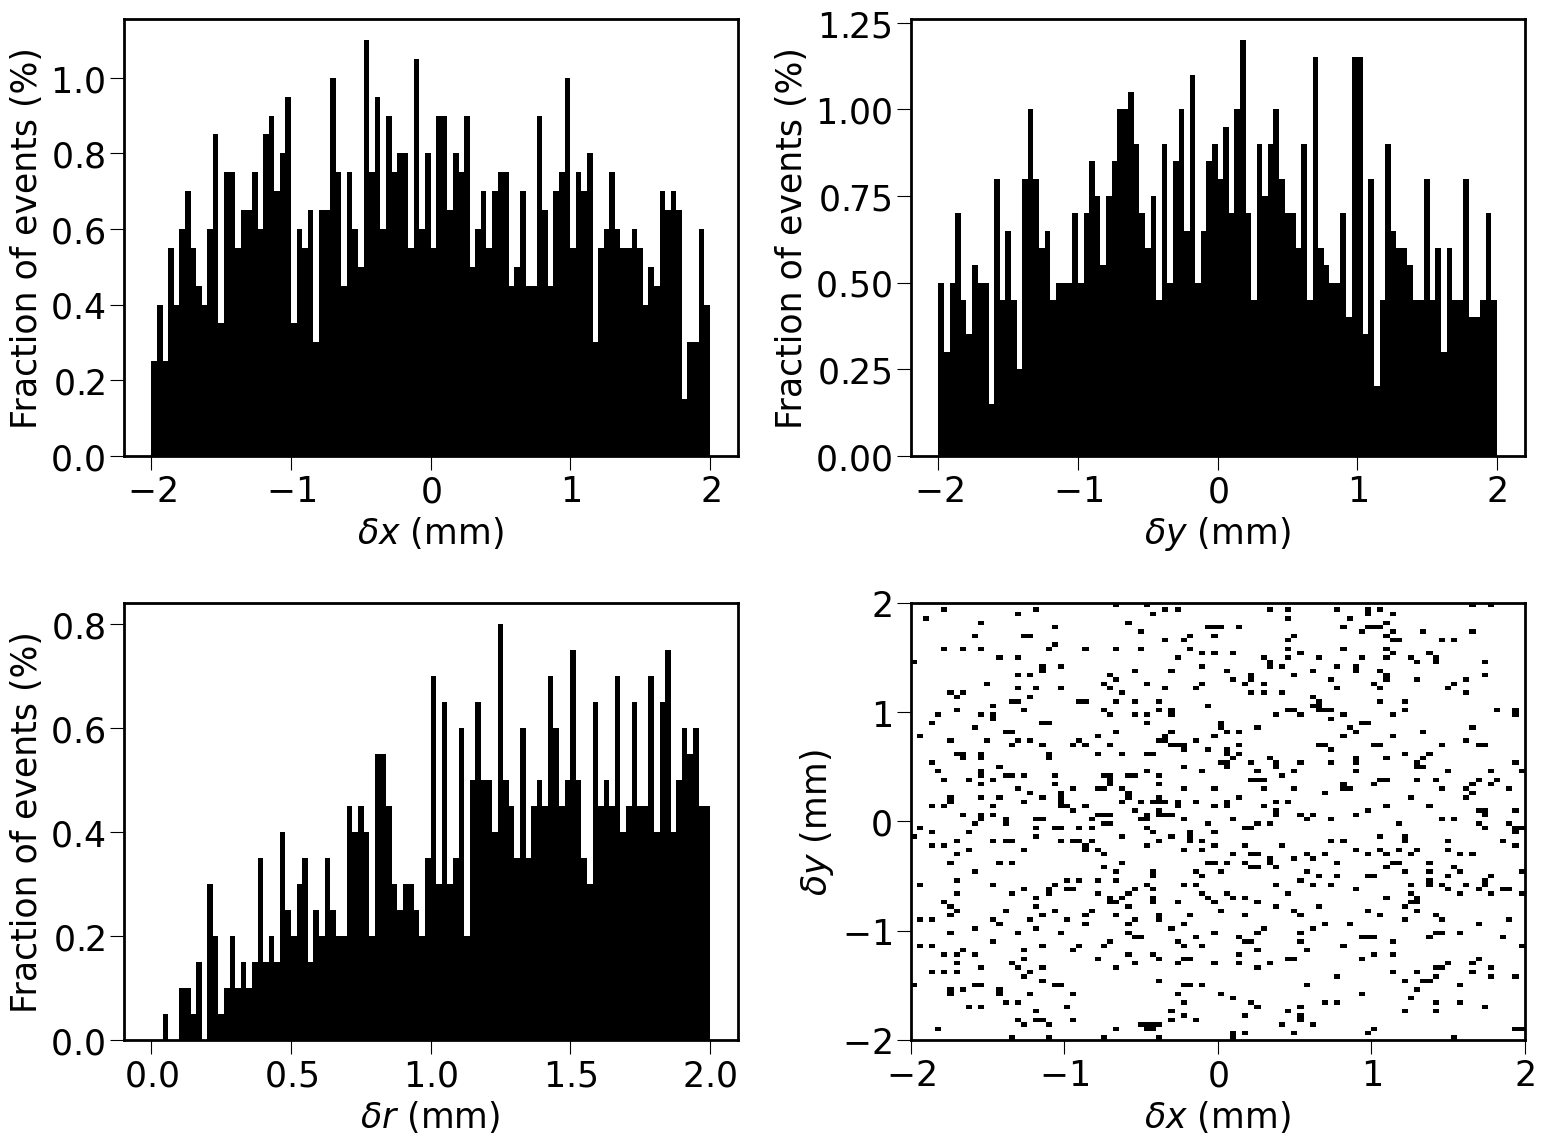

In [23]:
bins_dxy = np.linspace(-2, 2, 101)
bins_dr  = np.linspace( 0, 2, 101)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1); normhist(dxs, bins_dxy); plt.xlabel("$\delta x$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 2); normhist(dys, bins_dxy); plt.xlabel("$\delta y$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 3); normhist(dps, bins_dr ); plt.xlabel("$\delta r$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 4); plt.hist2d(dxs, dys, (bins_dxy,)*2, cmin=1); plt.xlabel("$\delta x$ (mm)"); plt.ylabel("$\delta y$ (mm)")

plt.tight_layout()

ValueError: x and y must have the same length.

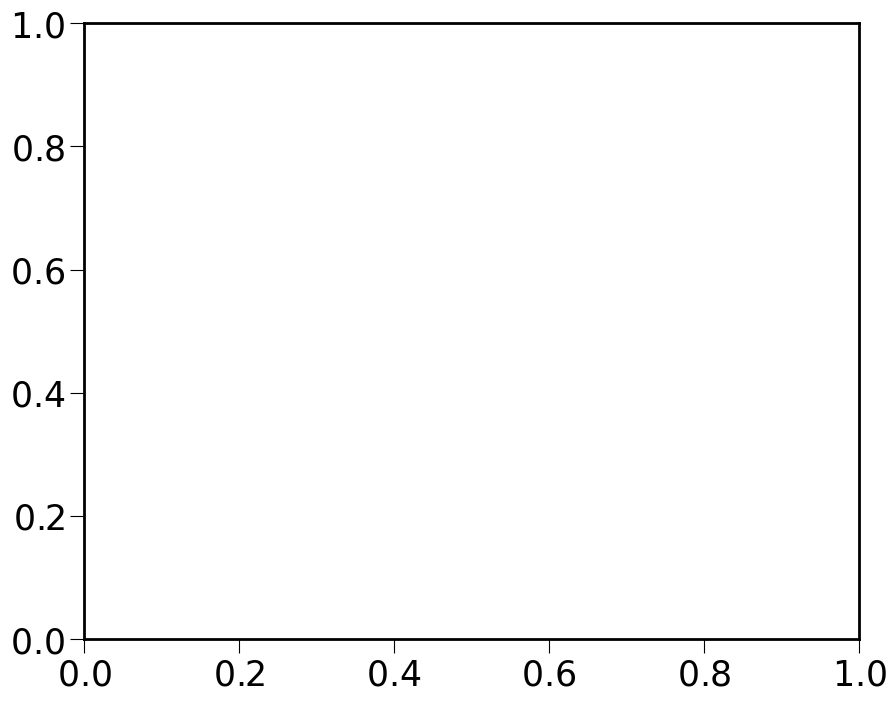

In [13]:
bins_r = np.linspace(0, bins_dxy.max(), 101)
plt.hist2d(ps, dps, (bins_r, bins_dr), cmin=1)
plt.xlabel(r"$\rho$  (mm)")
plt.ylabel(r"d$\rho$ (mm)")

plt.tight_layout()

1111


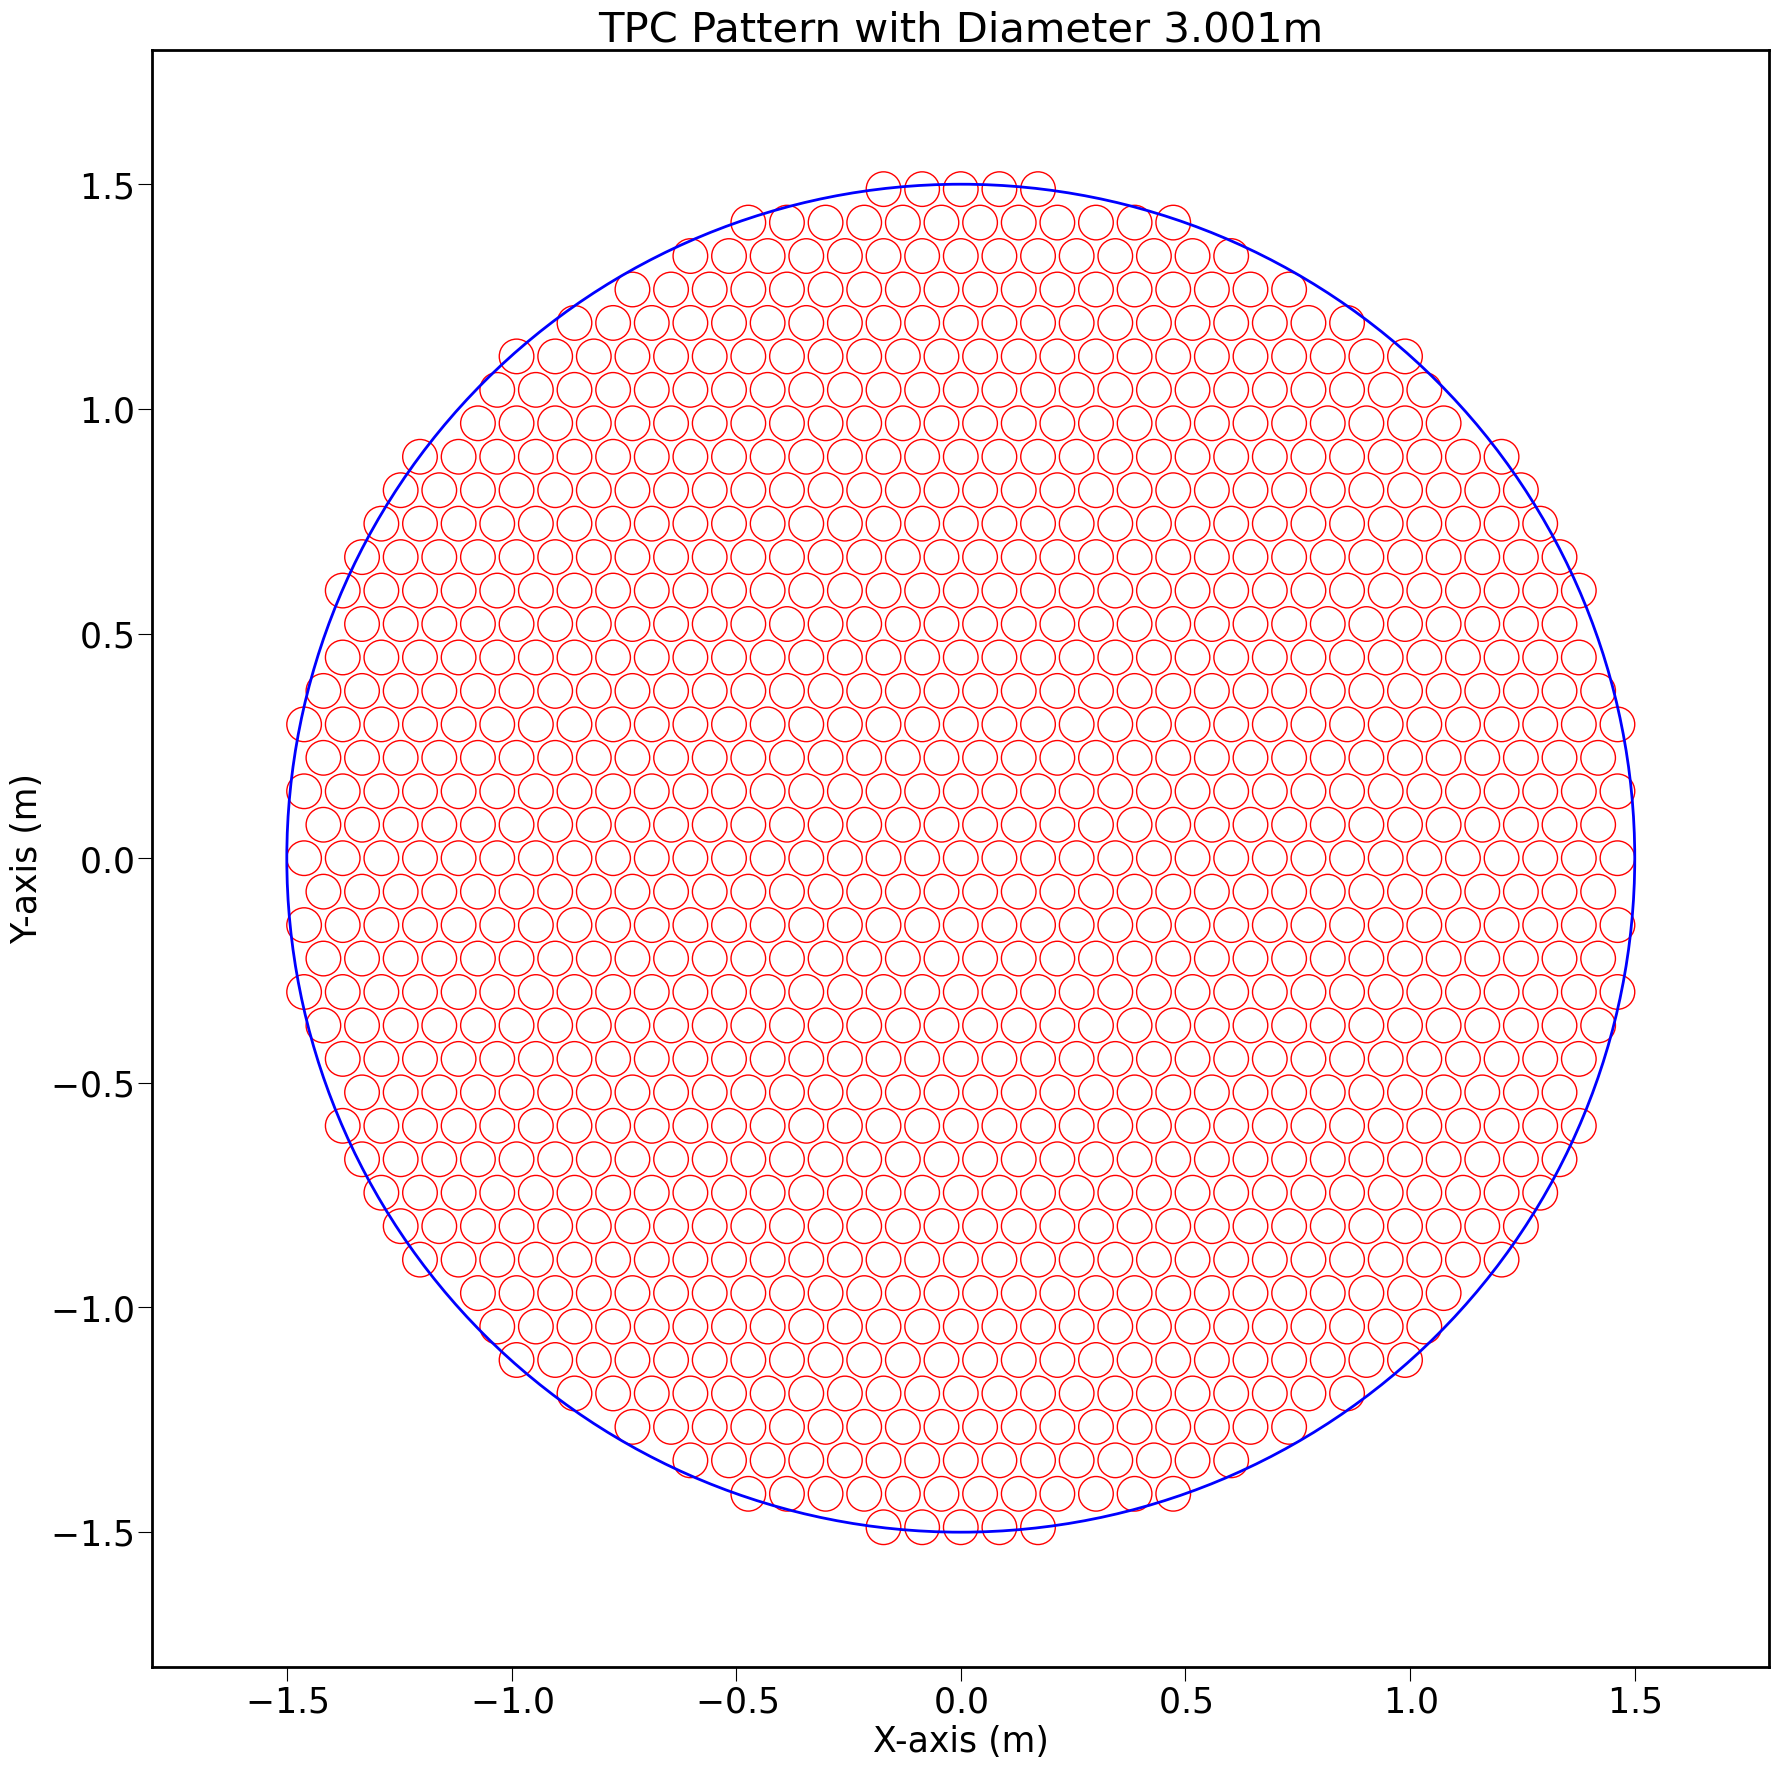

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def draw_progressive_tpc_pattern(num_rows, num_columns, circle_diameter):
    # Starting parameters
    p = 0.077 + 0.009  # pitch
    tpc_diameter = 0.077  # diameter of the TPC

    # List to store individual circles
    circles = []

    for tpc_diameter in np.arange(0.077, 3.002, 0.172):
        if tpc_diameter < 3: continue
        for i in range(-num_rows, num_rows+1):
            for j in range(-num_columns, num_columns+1):
                x = i * p + p * np.cos(np.pi / 3) * (j % 2)
                y = j * p * np.sin(np.pi / 3)

                # Skip the region already occupied by the TPC
                if (x**2 + y**2) >= (tpc_diameter / 2)**2:
                    continue

                # Append the circle at position (x, y) to the list
                circles.append(plt.Circle((x, y), circle_diameter / 2, fill=False, edgecolor='red', linewidth=1))
   
    print(len(circles))

    # Create a larger figure
    plt.figure(figsize=(21, 21))
    tpc_circle = plt.Circle((0, 0), tpc_diameter / 2, fill=False, color='blue', linewidth=2)
    circles.append(tpc_circle)
   
    # Add all circles to the final figure
    for circle in circles:
        plt.gca().add_patch(circle)

    # Set aspect ratio to be equal
    plt.gca().set_aspect('equal', adjustable='box')

    # Set xlim and ylim
    plt.xlim([-1.8, 1.8])
    plt.ylim([-1.8, 1.8])

    # Add labels and title
    plt.xlabel('X-axis (m)')
    plt.ylabel('Y-axis (m)')
    plt.title(f'TPC Pattern with Diameter {tpc_diameter:.3f}m')

    # Show the final plot
    plt.show()

# Call the function with the specified parameters
draw_progressive_tpc_pattern(num_rows=20, num_columns=20, circle_diameter=0.077)

1111


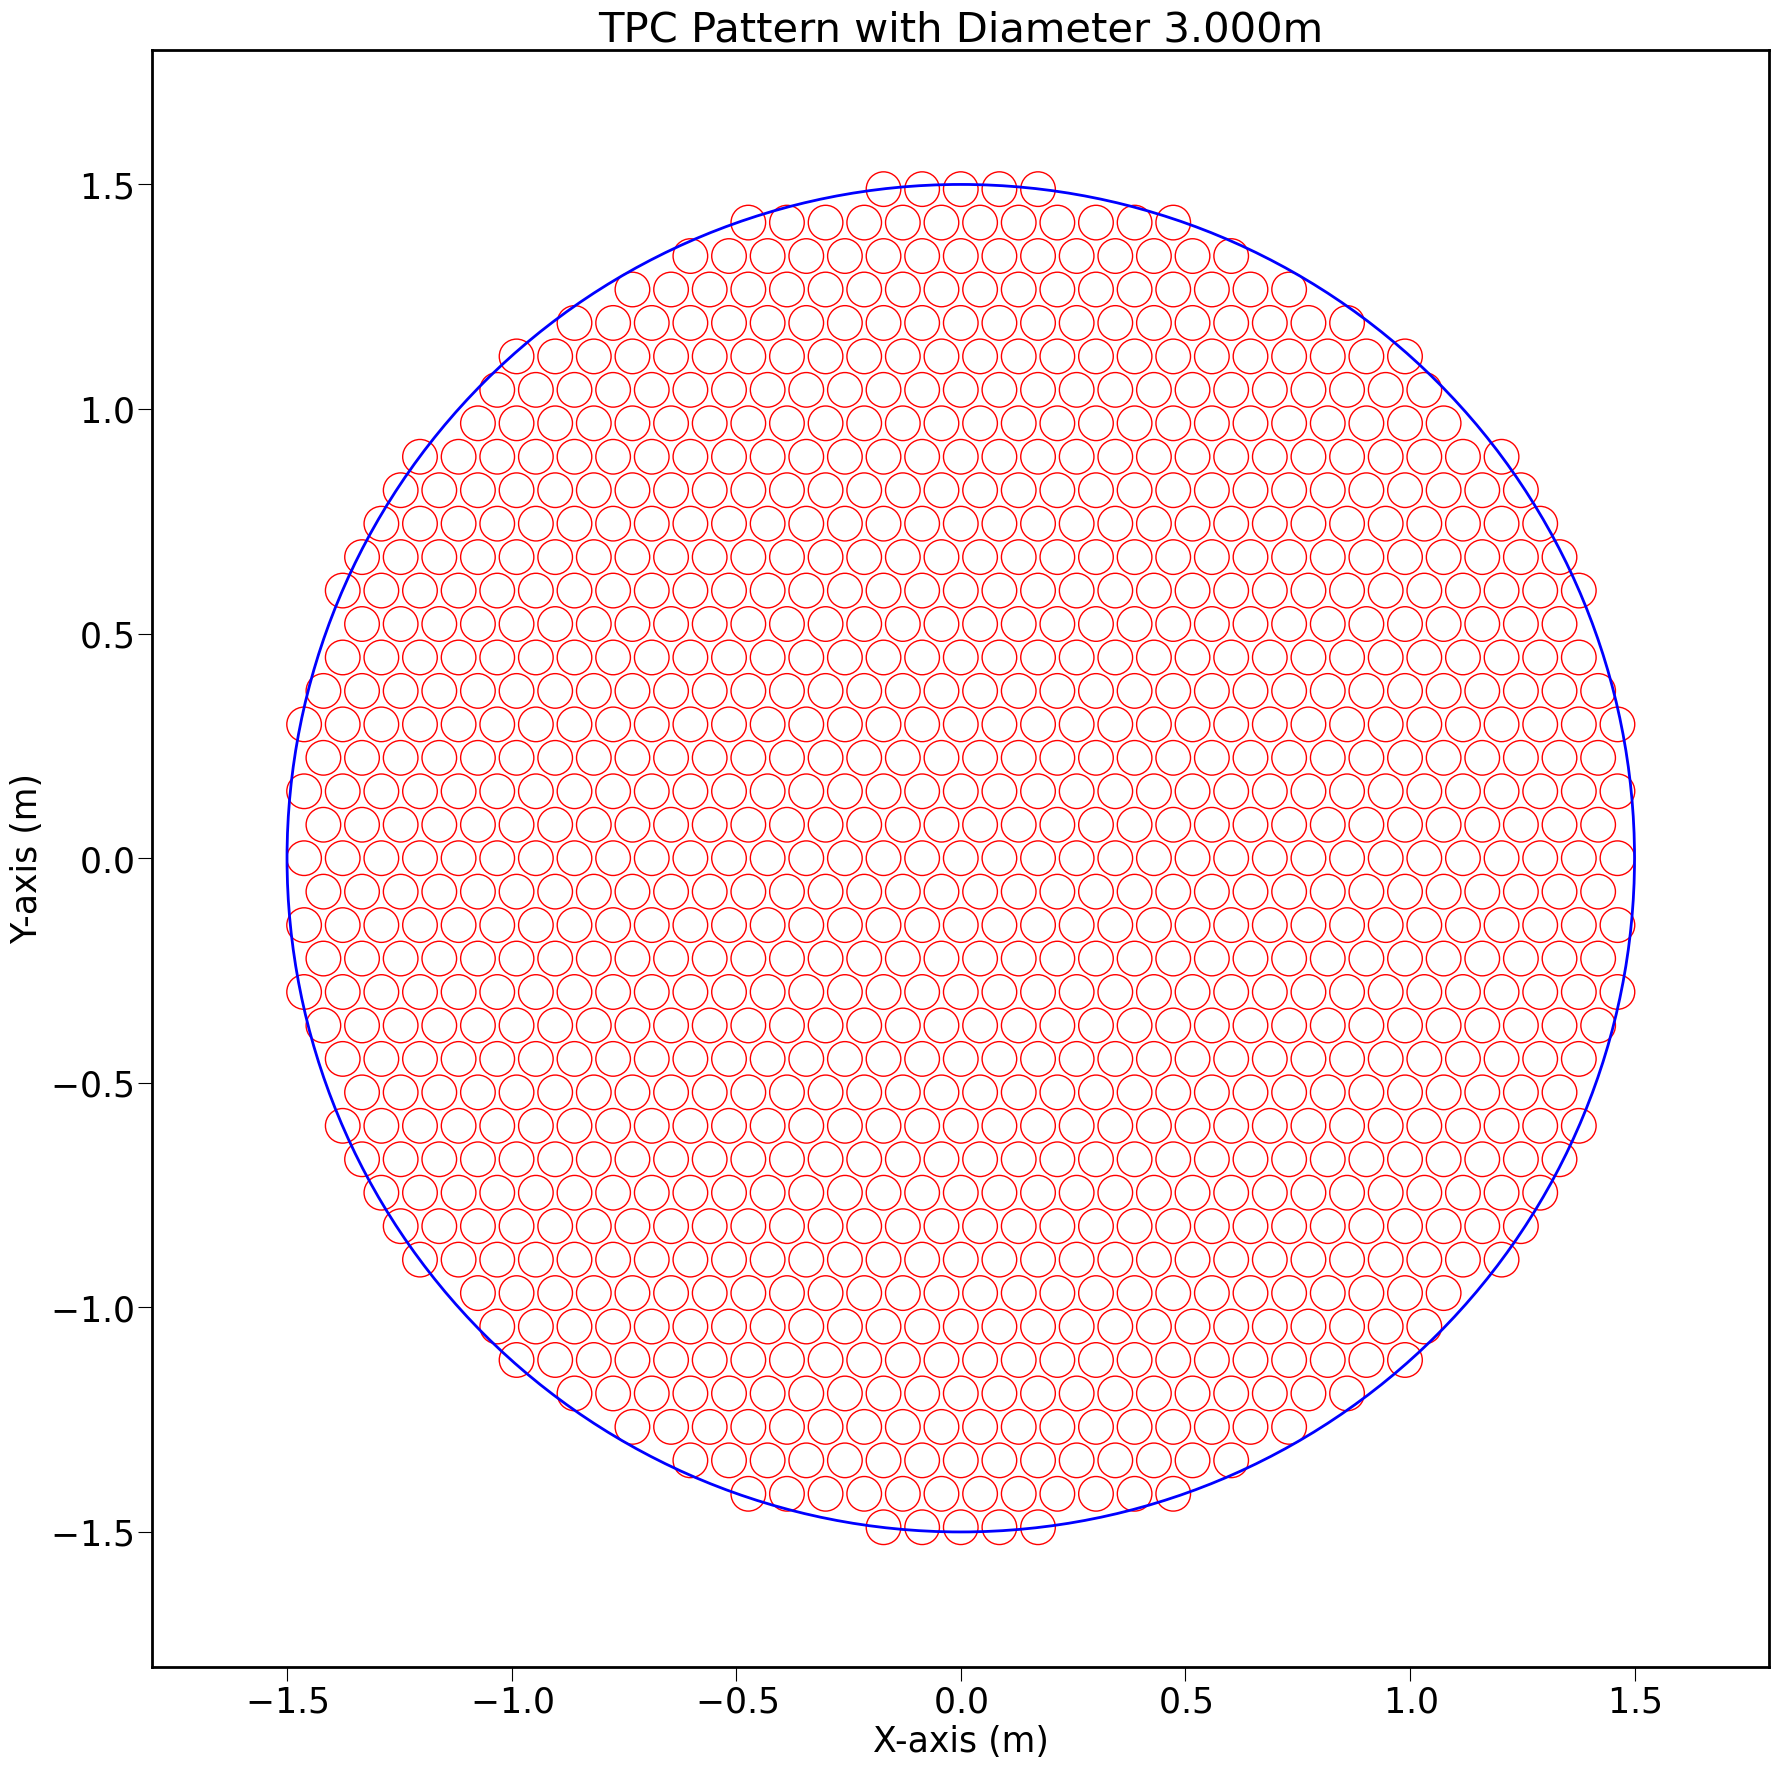

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def draw_progressive_tpc_pattern(num_rows, num_columns, circle_diameter, tpc_diameter):
    # Starting parameters
    p = 0.077 + 0.009  # pitch

    # List to store individual circles
    circles = []

    for i in range(-num_rows, num_rows+1):
        for j in range(-num_columns, num_columns+1):
            x = i * p + p * np.cos(np.pi / 3) * (j % 2)
            y = j * p * np.sin(np.pi / 3)

            # Skip the region already occupied by the TPC
            if (x**2 + y**2) >= (tpc_diameter / 2)**2:
                continue

            # Append the circle at position (x, y) to the list
            circles.append(plt.Circle((x, y), circle_diameter / 2, fill=False, edgecolor='red', linewidth=1))
   
    print(len(circles))

    # Create a larger figure
    plt.figure(figsize=(21, 21))
    tpc_circle = plt.Circle((0, 0), tpc_diameter / 2, fill=False, color='blue', linewidth=2)
    circles.append(tpc_circle)
   
    # Add all circles to the final figure
    for circle in circles:
        plt.gca().add_patch(circle)

    # Set aspect ratio to be equal
    plt.gca().set_aspect('equal', adjustable='box')

    # Set xlim and ylim
    plt.xlim([-1.8, 1.8])
    plt.ylim([-1.8, 1.8])

    # Add labels and title
    plt.xlabel('X-axis (m)')
    plt.ylabel('Y-axis (m)')
    plt.title(f'TPC Pattern with Diameter {tpc_diameter:.3f}m')

    # Show the final plot
    plt.show()

# Call the function with the specified parameters
draw_progressive_tpc_pattern(num_rows=20, num_columns=20, circle_diameter=0.077, tpc_diameter=3)